# fasion MNIST classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# 훈련, 테스트용 데이터 셋 받아오기 (파라미터들 1: 저장될 위치, 2: 하면서 학습시킬 건지, 3: 해당 파일이 없을 때만 다운로드, 4: 텐서로 변경)
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:00<00:00, 34438165.59it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8939549.58it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 25820141.03it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22680963.23it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# 데이터 셋 불러오기
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

In [6]:
print(train_loader.dataset.data[0].shape) # 28 x 28 픽셀의 값을 의미
# train_loader.dataset.data[0] # 0 ~ 255의 값으로 구성되어 있는데 아마 흑백사진에서 흰 정도를 의미할 것임.

torch.Size([28, 28])


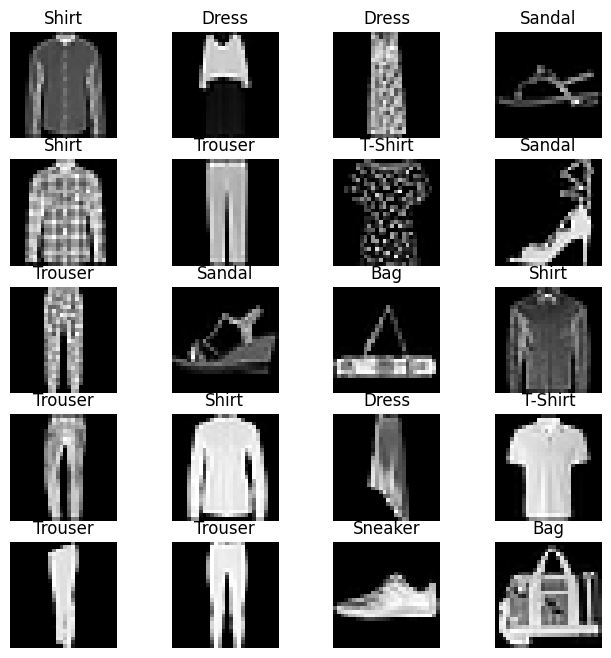

In [7]:
# 분류에 사용될 클래스를 정의하기

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

fig = plt.figure(figsize= (8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows+1): # 총 20개의 그림을 출력
    img_xy = np.random.randint(len(train_dataset)) # 훈련 데이터 셋의 수 중 랜덤으로 하나를 뽑는다
    img = train_dataset[img_xy][0][0,:,:] # 그 이미지를 가져온다
    fig.add_subplot(rows, columns, i) # 부분 그림 공간을 할당한 후
    plt.title(labels_map[train_dataset[img_xy][1]]) # 그 그림이 무슨 그림인지 표시해 줌
    plt.axis('off') # 축은 없애주고
    plt.imshow(img, cmap='gray') # 그 그림을 흑백으로 표시해 줌
plt.show()


In [8]:
# CNN과 DNN의 비교를 위해 먼저 DNN을 해보자

# 심층 신경망 (DNN) 모델 생성

class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(28*28, 256) # input은 28 x 28, 일단 256개로 줄임
    self.drop = nn.Dropout(0.25) # 과적합을 방지하기 위해 일부 쳐내고
    self.fc2 = nn.Linear(256, 128) # 한번 더
    self.fc3 = nn.Linear(128, 10) # output은 총 10개로 분류해야 하므로 10

  def forward(self, input_data):
    out = input_data.view(-1, 28*28) # 걍 쭉 펴버림. 이미지의 지역성을 그냥 무시해버림.
    out = F.relu(self.fc1(out)) # 28 * 28 to 256
    out = self.drop(out) # drop
    out = F.relu(self.fc2(out)) # 256 to 128
    out = self.fc3(out) # 128 to 10
    return out


In [9]:
# 심층 신경망에서 필요한 파라미터 정의

lr = 0.001
model = FashionDNN().to(device) # 이건 그냥 cpu 안쓰고 gpu 쓰겠다는 소리로 받아들이면 됨.

criterion = nn.CrossEntropyLoss() # 손실 함수 정의; 분류 문제에서는 cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 최적화 함수 정의
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# 모델도 다 만들었으니 이를 이용해서 학습해보자.

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs): # 총 5번을 실행할 것.
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28)) # batch가 100이고 흑백이므로 channel은 1.
    labels = Variable(labels)

    outputs = model(train) # 모델을 돌렸을 때 나오는 결과
    loss = criterion(outputs, labels) # 이 결과와 실제 정답 간에 손실 (차이)
    optimizer.zero_grad() # 기울기를 초기화 하고
    loss.backward() # 기울기 계산하고
    optimizer.step() # 기울기를 통해 파라미터 업데이트
    count += 1

    if not (count % 50): # 50번 마다 실행
      total = 0
      correct = 0

      # 여기서 부터 값이 잘 맞는지 예측하는 것.
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum() # 예측한 값과 실제 값이 같으면 + 1
        total += len(labels) # 그냥 + 1

      accuracy = 100 * correct / float(total) # 정확도 계산
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

      if not (count % 500): # 500번 마다 어떻게 변하는지 관찰
        print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.5478280782699585, Accuracy: 83.25%
Iteration: 1000, Loss: 0.4952824115753174, Accuracy: 84.79999542236328%
Iteration: 1500, Loss: 0.33389654755592346, Accuracy: 84.0199966430664%
Iteration: 2000, Loss: 0.31945380568504333, Accuracy: 85.73999786376953%
Iteration: 2500, Loss: 0.2814418077468872, Accuracy: 86.23999786376953%
Iteration: 3000, Loss: 0.2687707543373108, Accuracy: 86.44999694824219%


In [11]:
# 이번엔 비교를 위해 합성곱 신경망 (CNN)을 해보자

class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        # 흑백이므로 채널은 1, -> 32로 변경함; 필터는 3 x 3을 쓰고 패딩은 1을 줌. 출력 크기 조정을 위해 테두리에 0을 넣는 것.
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        # 이 32개의 채널을 정규화 시킴
        nn.BatchNorm2d(32),
        # 렐루 쓸거고
        nn.ReLU(),
        # 2 x 2 커널 사이즈로 2칸씩 이동하여 풀링; 이미지 크기를 축소 시킴
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 결국 10개로 줄임.

  # 위에서 정의해 놓은 걸로 순전파 진행하는 함수
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out


In [12]:
# 파라미터 정의

lr = 0.001
model = FashionCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
# 학습 및 평가 진행

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs): # 총 5번을 실행할 것.
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28)) # batch가 100이고 흑백이므로 channel은 1.
    labels = Variable(labels)

    outputs = model(train) # 모델을 돌렸을 때 나오는 결과
    loss = criterion(outputs, labels) # 이 결과와 실제 정답 간에 손실 (차이)
    optimizer.zero_grad() # 기울기를 초기화 하고
    loss.backward() # 기울기 계산하고
    optimizer.step() # 기울기를 통해 파라미터 업데이트
    count += 1

    if not (count % 50): # 50번 마다 실행
      total = 0
      correct = 0

      # 여기서 부터 값이 잘 맞는지 예측하는 것.
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum() # 예측한 값과 실제 값이 같으면 + 1
        total += len(labels) # 그냥 + 1

      accuracy = 100 * correct / float(total) # 정확도 계산
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

      if not (count % 500): # 500번 마다 어떻게 변하는지 관찰
        print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4638470709323883, Accuracy: 87.98999786376953%
Iteration: 1000, Loss: 0.35158607363700867, Accuracy: 88.52999877929688%
Iteration: 1500, Loss: 0.2873722314834595, Accuracy: 87.83999633789062%
Iteration: 2000, Loss: 0.1832359880208969, Accuracy: 89.54999542236328%
Iteration: 2500, Loss: 0.1106405034661293, Accuracy: 89.44999694824219%
Iteration: 3000, Loss: 0.1876811981201172, Accuracy: 90.48999786376953%


In [14]:
# 전이 학습: 아주 많은 데이터를 통해 학습된 모델의 가중치를 가져와서 우리가 해결하는 과제에 맞게 보정하여 사용하는 것.

# !pip install opencv-python

In [15]:
import os
import time
import copy
import glob
import cv2 # 저 위에 pip로 설치한 라이브러리
import shutil

import torchvision # 컴퓨터 비전용
import torchvision.transforms as transforms # 데이터 전처리용
import torchvision.models as models # VGG나 ResNet 같은 네트워크를 사용하게 도와줌.
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [16]:
# 미리 받아논 개/고양이 훈련 데이터 위치
data_path = '/content/drive/MyDrive/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size= 32, num_workers= 8, shuffle= True)

print(len(train_dataset))


385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


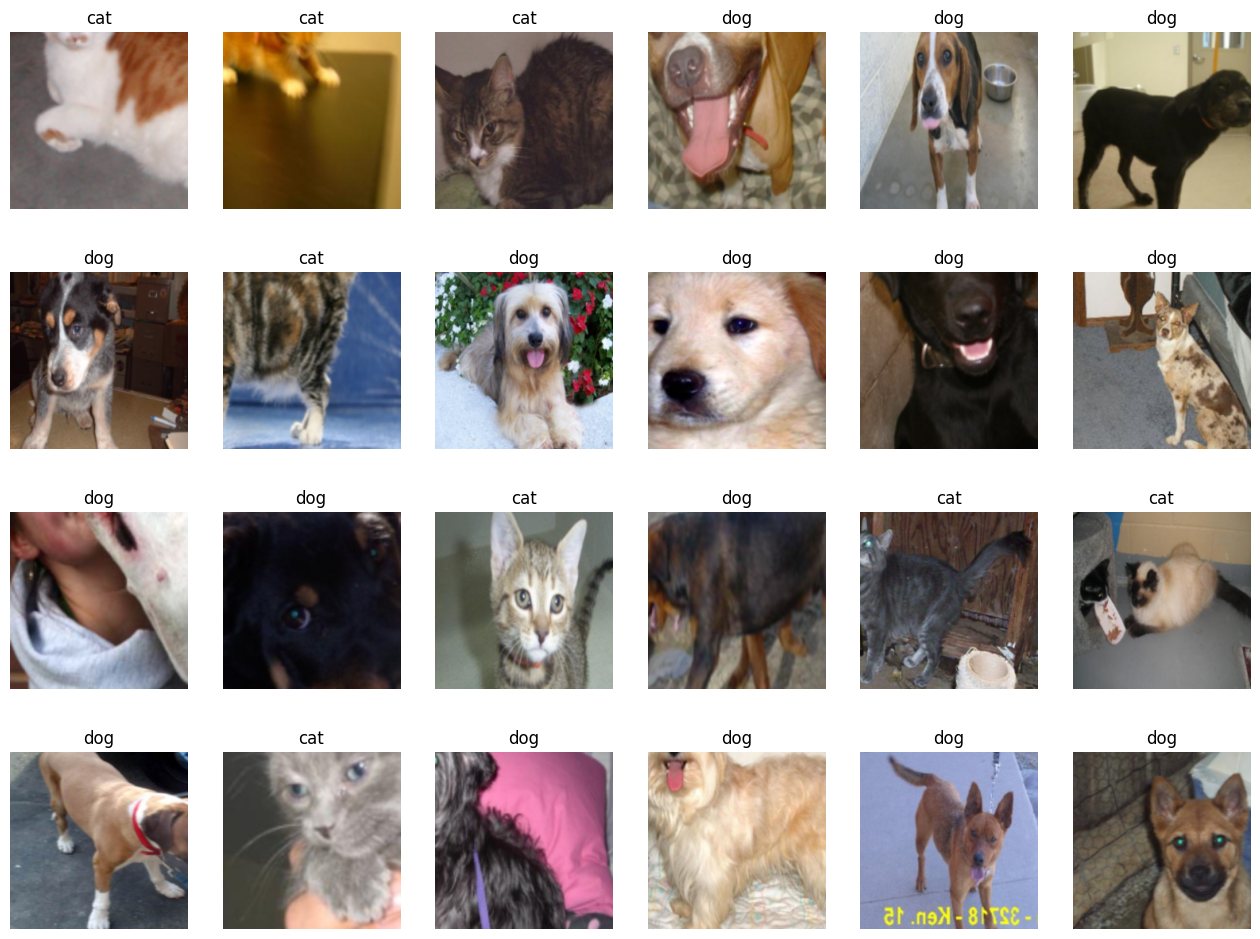

In [17]:
# 가져온 이미지 조금 출력해봐서 잘 가져왔는지 확인해보자.

sample, labels = next(iter(train_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize= (16, 24))
for i in range(24):
  a = fig.add_subplot(4, 6, i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(sample[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom= 0.2, top= 0.6, hspace= 0)
plt.show()

In [18]:
# 데이터 전처리는 끝났으니까 네트워크를 가져오자.

resnet18 = models.resnet18(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [19]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 파라미터들에 대한 변화를 계산하지 않음. 고정

set_parameter_requires_grad(resnet18)

In [20]:
resnet18.fc = nn.Linear(512, 2) # 마지막 레이어 하나를 붙여서 출력 데이터를 2로 만들어 줌.

In [21]:
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0096,  0.0048, -0.0357,  ..., -0.0024,  0.0339,  0.0208],
        [ 0.0209,  0.0296,  0.0087,  ..., -0.0424,  0.0390,  0.0050]])
fc.bias tensor([0.0297, 0.0292])


In [22]:
model = models.resnet18(pretrained = True) # 모델 생성

for param in model.parameters():
    param.requires_grad = False # 가중치 고정

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True # 마지막 레이어만 학습

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# 모델 학습을 위한 함수

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [24]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5898 Acc: 0.6571

Epoch 1/12
----------
Loss: 0.4244 Acc: 0.8182

Epoch 2/12
----------
Loss: 0.3079 Acc: 0.8987

Epoch 3/12
----------
Loss: 0.3116 Acc: 0.8883

Epoch 4/12
----------
Loss: 0.2584 Acc: 0.9013

Epoch 5/12
----------
Loss: 0.3393 Acc: 0.8494

Epoch 6/12
----------
Loss: 0.2199 Acc: 0.9247

Epoch 7/12
----------
Loss: 0.2394 Acc: 0.8987

Epoch 8/12
----------
Loss: 0.1983 Acc: 0.9325

Epoch 9/12
----------
Loss: 0.2186 Acc: 0.9169

Epoch 10/12
----------
Loss: 0.1850 Acc: 0.9403

Epoch 11/12
----------
Loss: 0.2171 Acc: 0.9065

Epoch 12/12
----------
Loss: 0.2041 Acc: 0.9247

Training complete in 1m 50s
Best Acc: 0.940260


In [26]:
test_path = '/content/drive/MyDrive/data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [27]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [28]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/data/catanddog/00.pth', '/content/drive/MyDrive/data/catanddog/01.pth', '/content/drive/MyDrive/data/catanddog/02.pth', '/content/drive/MyDrive/data/catanddog/03.pth', '/content/drive/MyDrive/data/catanddog/04.pth', '/content/drive/MyDrive/data/catanddog/05.pth', '/content/drive/MyDrive/data/catanddog/06.pth', '/content/drive/MyDrive/data/catanddog/07.pth', '/content/drive/MyDrive/data/catanddog/08.pth', '/content/drive/MyDrive/data/catanddog/09.pth', '/content/drive/MyDrive/data/catanddog/10.pth', '/content/drive/MyDrive/data/catanddog/11.pth', '/content/drive/MyDrive/data/catanddog/12.pth']
Loading model /content/drive/MyDrive/data/catanddog/00.pth


<ipython-input-27-d5a346dcee2f>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 0.8878

Loading model /content/drive/MyDrive/data/catanddog/01.pth
Acc: 0.8980

Loading model /content/drive/MyDrive/data/catanddog/02.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/data/catanddog/03.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/04.pth
Acc: 0.9184

Loading model /content/drive/MyDrive/data/catanddog/05.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/06.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/07.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/data/catanddog/08.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/data/catanddog/09.pth
Acc: 0.9184

Loading model /content/drive/MyDrive/data/catanddog/10.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/11.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/12.pth
Acc: 0.9286

Validation complete in 1m 3s
Best Acc: 0.938776


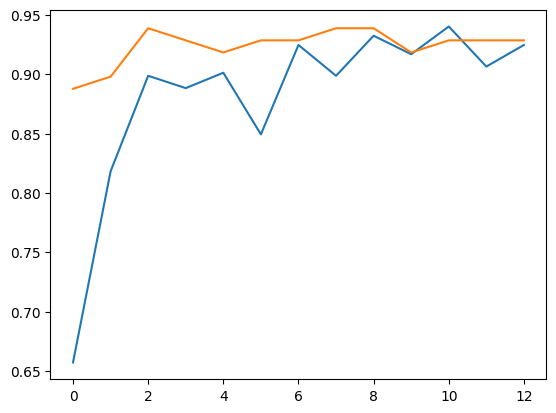

In [29]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

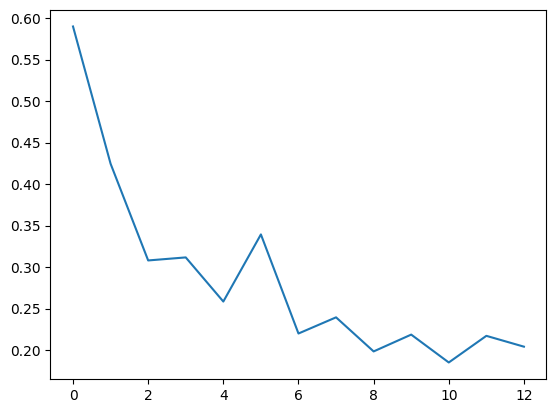

In [30]:
plt.plot(train_loss_hist)
plt.show()

In [31]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

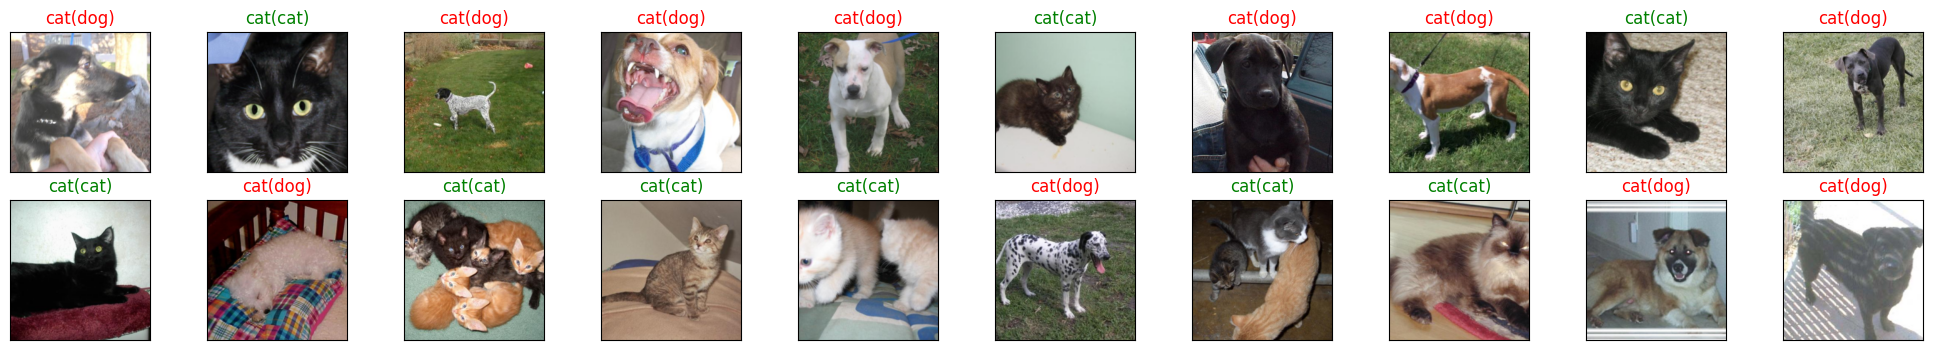

<Figure size 640x480 with 0 Axes>

In [32]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images,labels=next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)